In [397]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wave
from statistics import mean
from scipy.fft import rfft, rfftfreq, irfft
from scipy.signal import welch, spectrogram

In [398]:
path = "data/BelaBartok_Sz56_III.wav"
sample_rate, song_data = wave.read(path)

stereo_left, stereo_right = song_data[:,0], song_data[:,1]
n_samples = len(stereo_left)
times = np.linspace(0, n_samples/sample_rate, n_samples)


In [399]:
def key_to_freq(n):
    "takes the nth key of an idealized piano and returns the frequency in [Hz]"
    return 2**((n-49)/12) * 440 

def freq_to_key(f):
    "takes a frequency in [Hz] and returns the corresponding key of an idealized piano"
    return int(round(12*np.log2(f/440) + 49))

piano_min_freq = key_to_freq(1)
piano_max_freq = key_to_freq(88)
piano_freqs = np.array([round(key_to_freq(n),4) for n in range(1,89)])

#piano_octave_notes_full = ['C', 'C#/Db', 'D', 'D#/Eb', 'E', 'F', 'F#/Gb', 'G', 'G#/Ab', 'A', 'A#/Bb', 'B']
piano_octave_notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
piano_notes = ['A0', 'A#0', 'B0'] + [n+str(i) for i in range(1,8) for n in piano_octave_notes] + ['C8']


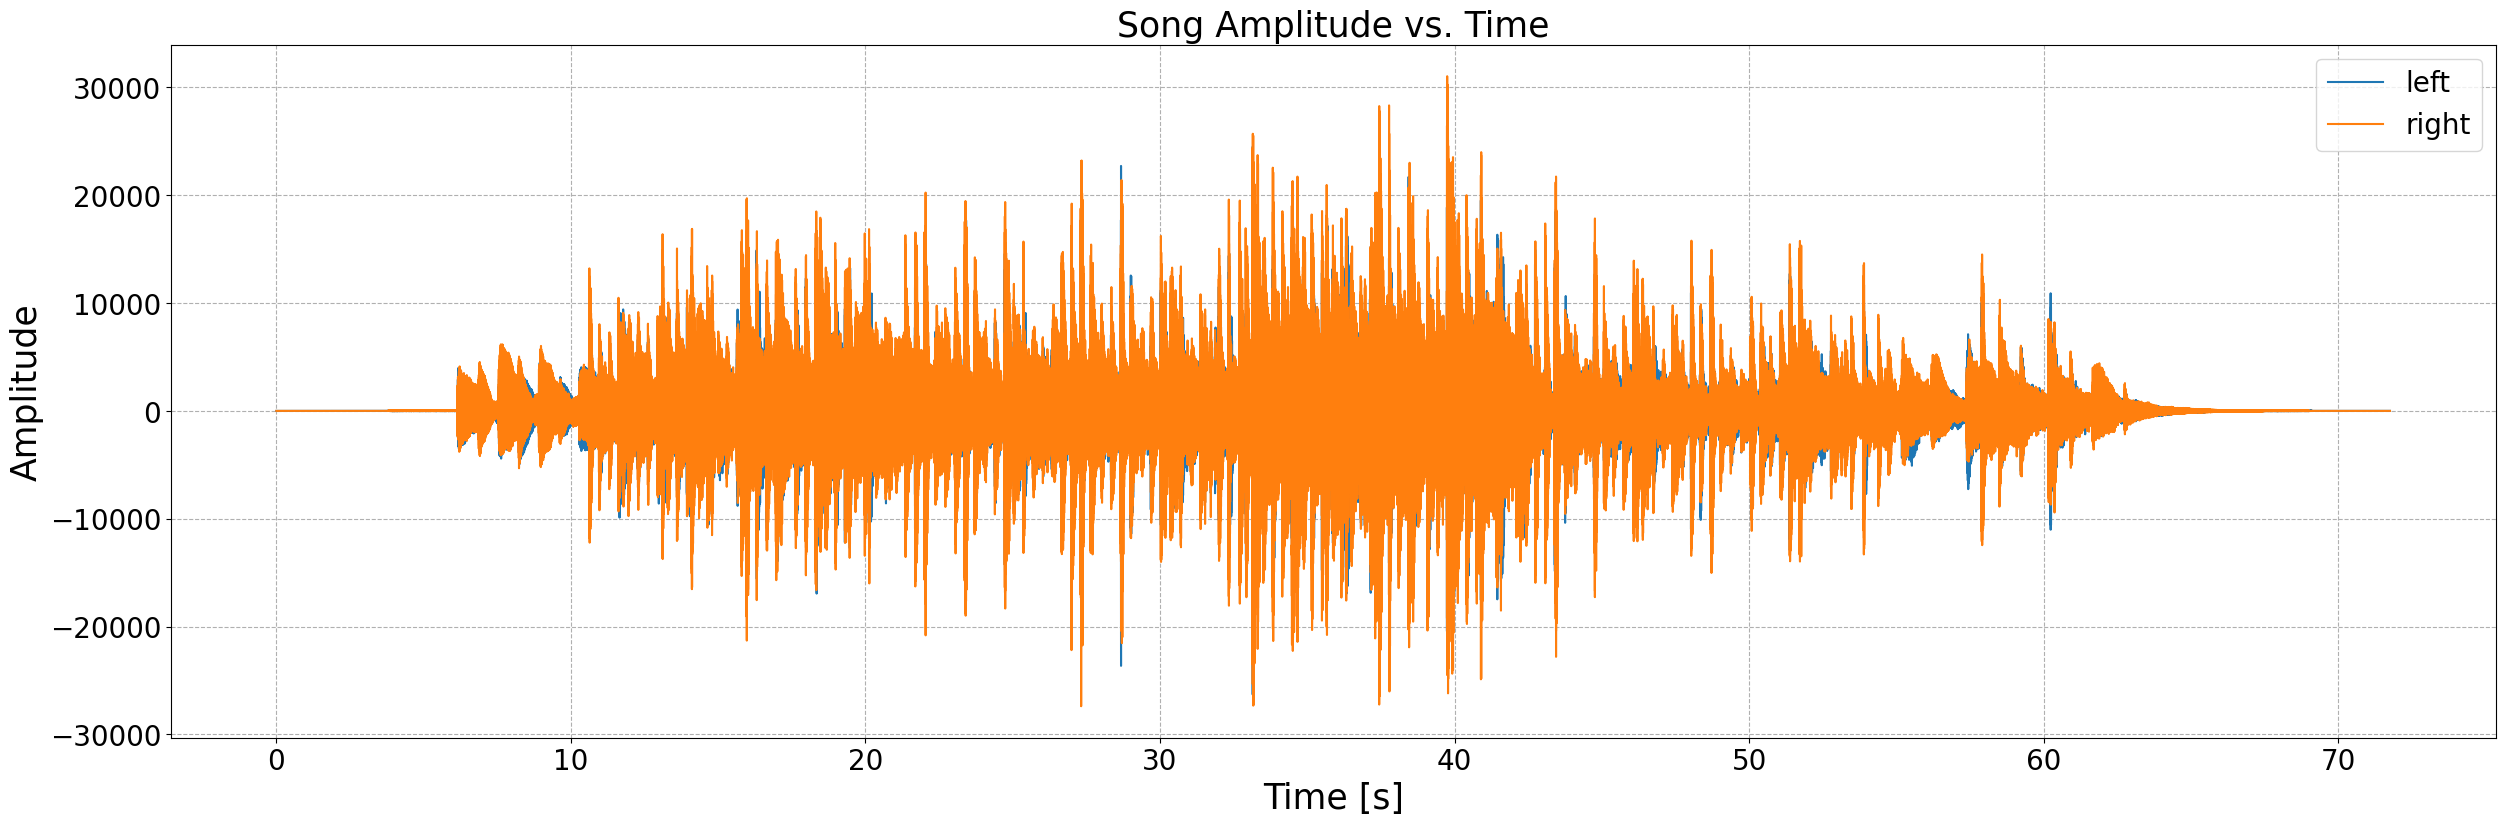

In [400]:
plt.figure(figsize=(30,9))
plt.plot(times, stereo_left, label='left')
plt.plot(times, stereo_right, label='right')
plt.title('Song Amplitude vs. Time', fontsize=25)
plt.ylabel('Amplitude', fontsize=25)
plt.xlabel('Time [s]', fontsize=25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.legend(fontsize=20)
plt.grid(True,linestyle='--')
plt.show()


In [433]:
# fft_freqs, left_fft = welch(stereo_left, fs=sample_rate, nperseg=int(len(stereo_left)/50))
# fft_freqs, right_fft = welch(stereo_right, fs=sample_rate, nperseg=int(len(stereo_right)/50))
fft_freqs = rfftfreq(stereo_left.size, 1/sample_rate)
left_fft = np.abs(rfft(stereo_left))
right_fft = np.abs(rfft(stereo_right))
steps_per_hz = len(fft_freqs)/fft_freqs[-1]


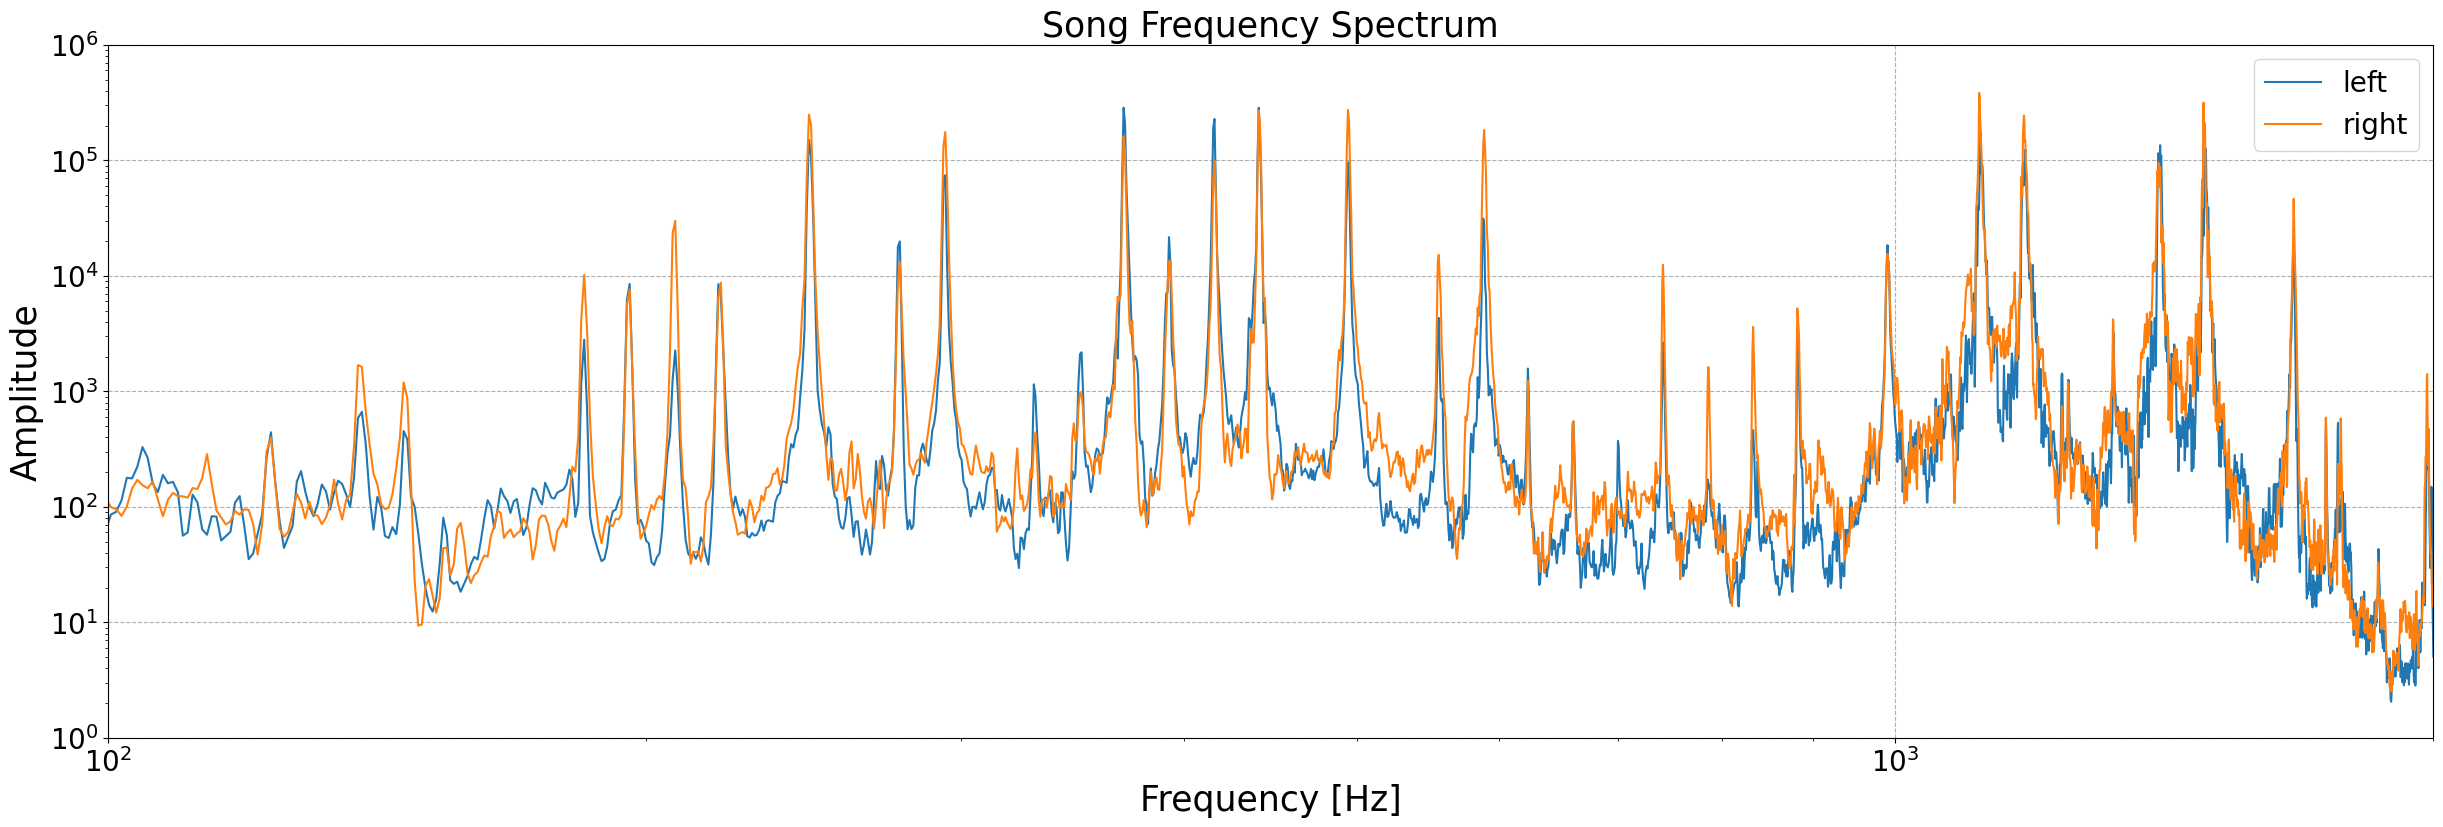

In [411]:
plt.figure(figsize=(30,9))
plt.plot(fft_freqs, left_fft, label='left')
plt.plot(fft_freqs, right_fft, label='right')
plt.title('Song Frequency Spectrum', fontsize=25)
plt.ylabel('Amplitude', fontsize=25)
plt.xlabel('Frequency [Hz]', fontsize=25)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1,1e6)
plt.xlim(1e2,2e3)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.legend(fontsize=20)
plt.grid(True,linestyle='--')
plt.show()


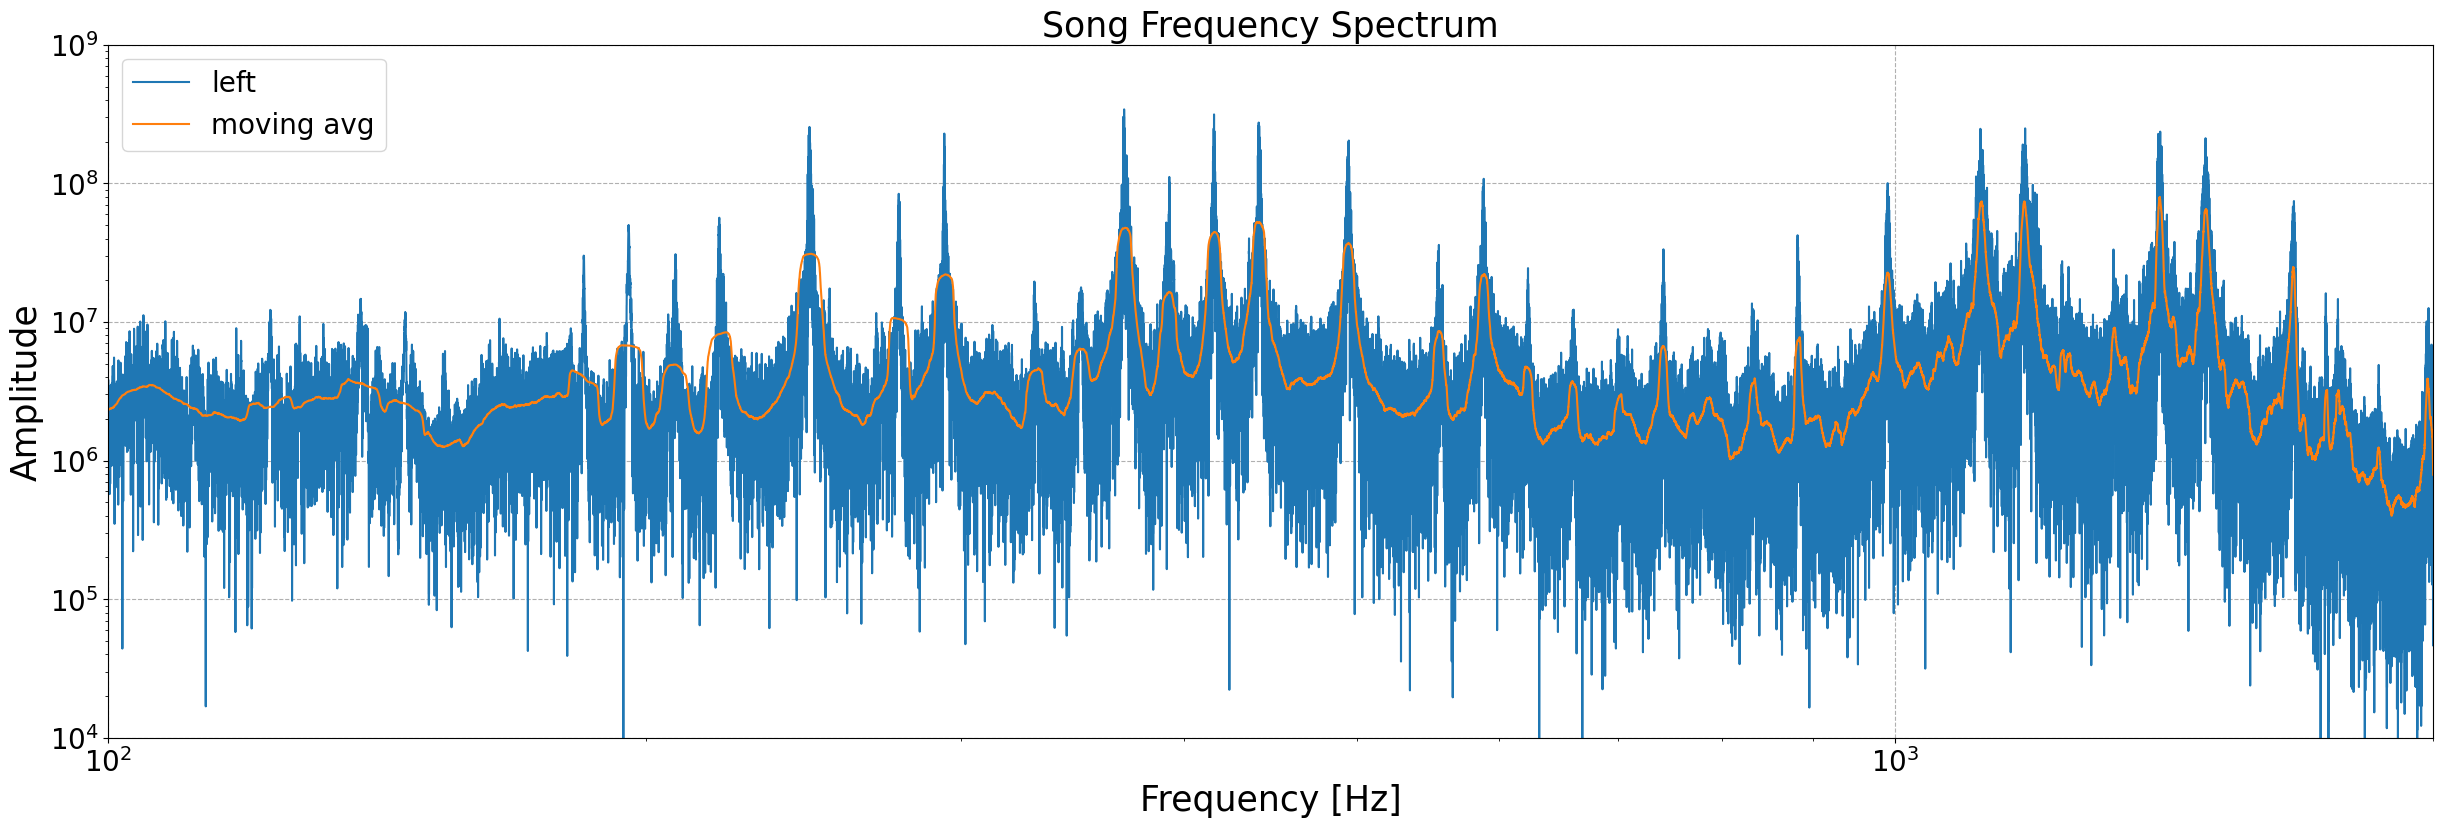

In [450]:
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

freqs_avg = movingaverage(left_fft, 500)

plt.figure(figsize=(30,9))
plt.plot(fft_freqs, left_fft, label='left')
plt.plot(fft_freqs, freqs_avg, label='moving avg')
plt.title('Song Frequency Spectrum', fontsize=25)
plt.ylabel('Amplitude', fontsize=25)
plt.xlabel('Frequency [Hz]', fontsize=25)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e4,1e9)
plt.xlim(1e2,2e3)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.legend(fontsize=20)
plt.grid(True,linestyle='--')
plt.show()


In [451]:
left_fft_smoothed = left_fft-freqs_avg
left_fft_smoothed[left_fft_smoothed<0] = 0


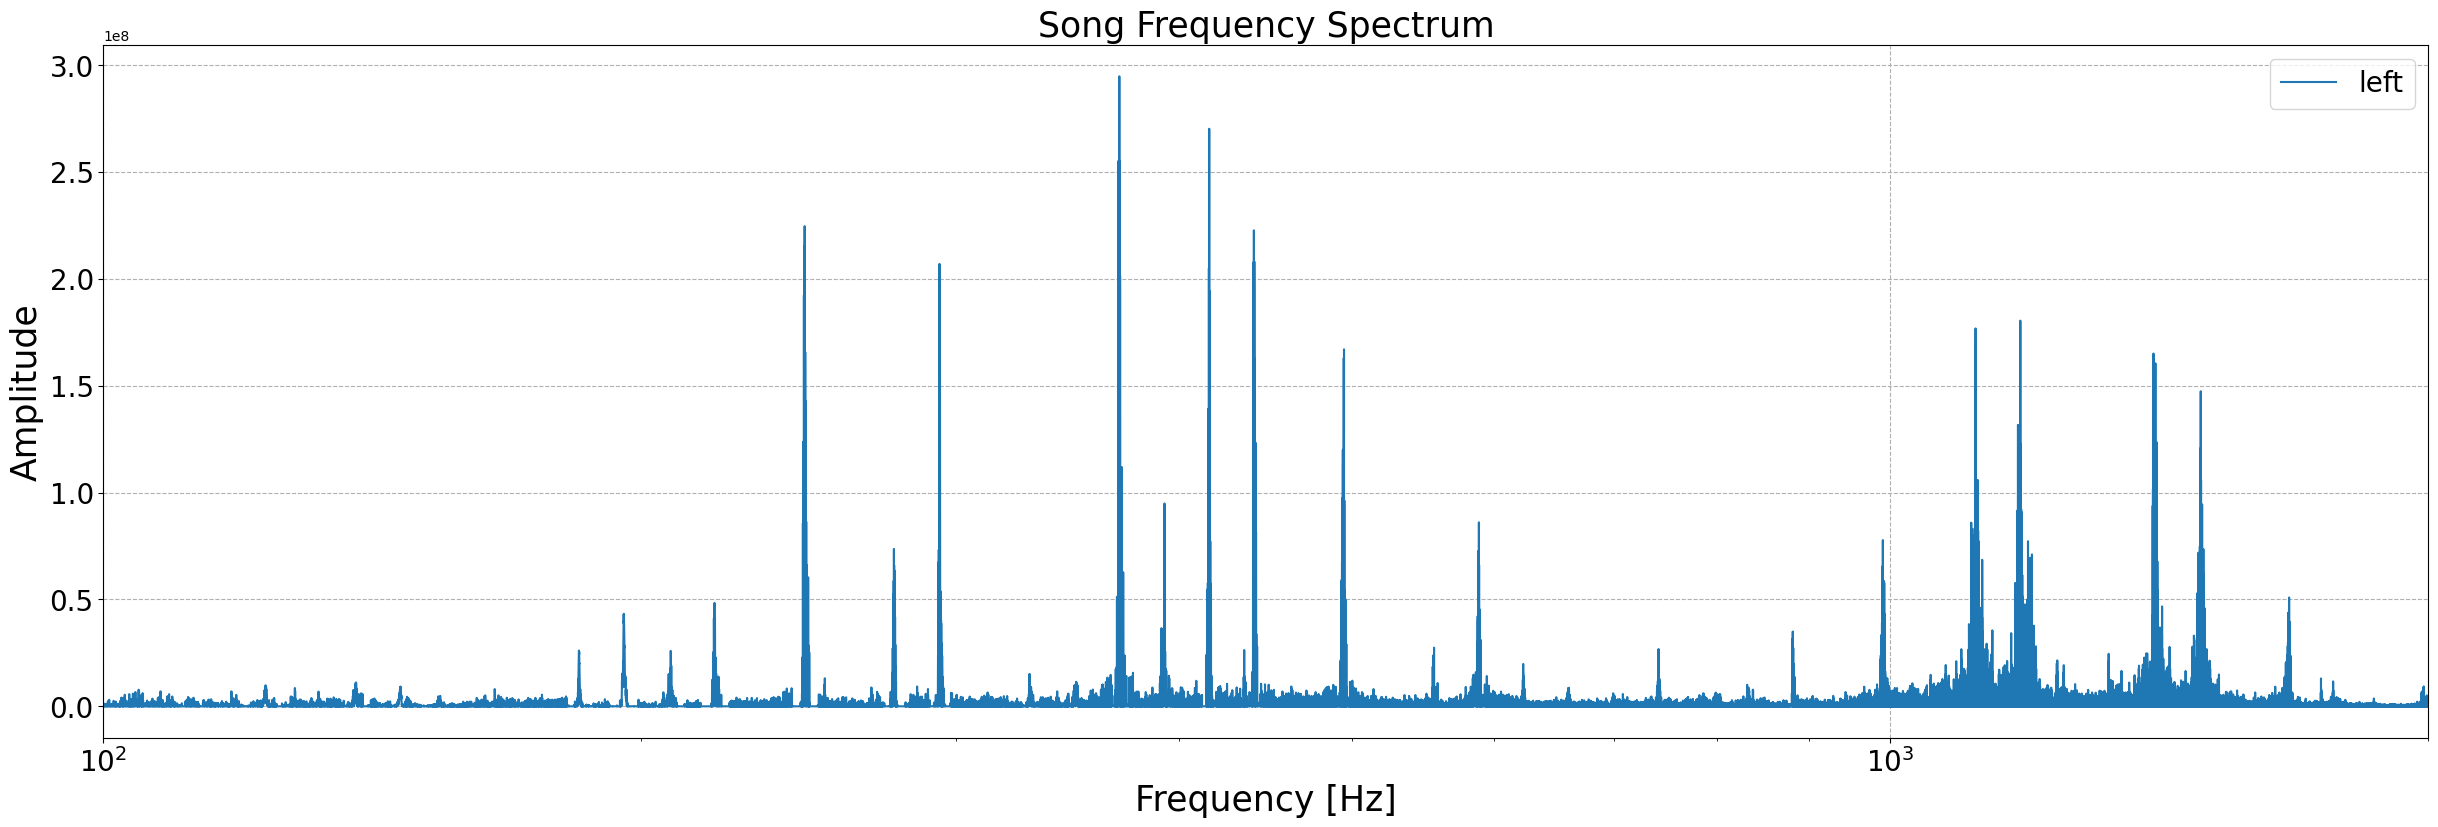

In [453]:
plt.figure(figsize=(30,9))
plt.plot(fft_freqs, left_fft_smoothed, label='left')
plt.title('Song Frequency Spectrum', fontsize=25)
plt.ylabel('Amplitude', fontsize=25)
plt.xlabel('Frequency [Hz]', fontsize=25)
#plt.yscale('log')
plt.xscale('log')
#plt.ylim(1,1e6)
plt.xlim(1e2,2e3)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.legend(fontsize=20)
plt.grid(True,linestyle='--')
plt.show()


In [460]:
# filtering to only include frequencies within the standard piano range of 27.5 - 4186.01 Hz
left_fft_filtered = np.array([value for value in left_fft_smoothed])
left_fft_filtered[0:int(piano_min_freq*steps_per_hz)] = 0
left_fft_filtered[int(piano_max_freq*steps_per_hz):] = 0

# filtering to only include frequencies with sufficient amplitude to constitute a played note (~10% of max amplitude)
max_played_amplitude = max(left_fft_filtered)
#min_played_amplitude = 1e-4*max_played_amplitude
# left_fft_filtered[left_fft_filtered-min_played_amplitude<0] = 0
# song_min_freq = next(i/steps_per_hz for i,val in enumerate(left_fft_filtered) if val>0)
# song_max_freq = next((left_fft_filtered.size-i)/steps_per_hz for i,val in enumerate(left_fft_filtered[::-1]) if val>0)

#print(f'min: {song_min_freq:.2f} Hz, max: {song_max_freq:.2f} Hz')


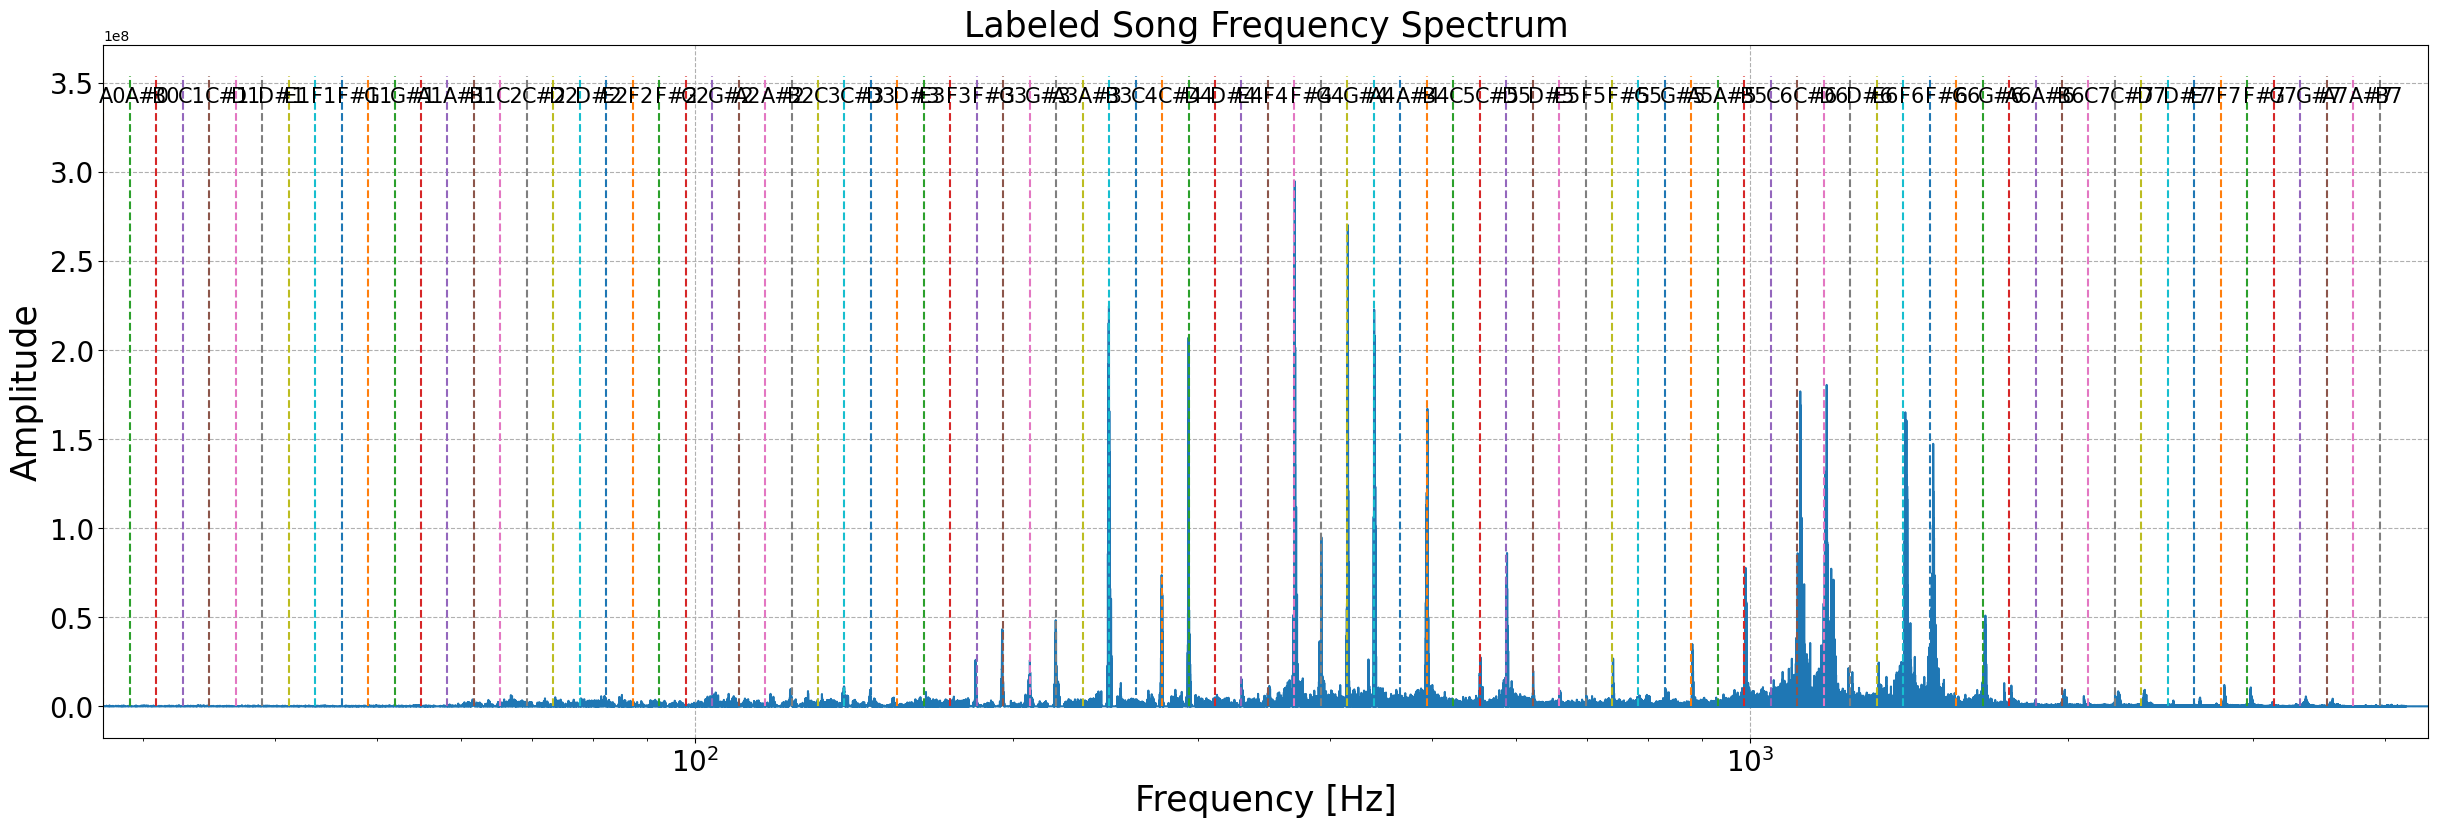

In [462]:
# plotting frequency spectrum with frequencies of all 88 piano notes labeled
plt.figure(figsize=(30,9))
plt.plot(fft_freqs, left_fft_filtered)
plt.xlim(piano_min_freq, 1.05*song_max_freq)
for n, freq in enumerate(piano_freqs[(piano_freqs>song_min_freq) & (piano_freqs<song_max_freq)]):
    plt.plot((freq, freq), (0, 1.2*max_played_amplitude), linestyle='--')
    plt.text(.99*freq, 1.15*max_played_amplitude, piano_notes[freq_to_key(freq)-1], fontsize=15)
#plt.yscale('log')
plt.xscale('log')
plt.title('Labeled Song Frequency Spectrum', fontsize=25)
plt.ylabel('Amplitude', fontsize=25)
plt.xlabel('Frequency [Hz]', fontsize=25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.grid(True,linestyle='--')
plt.show()


In [406]:
left_spectrogram = spectrogram(stereo_left_filtered, fs = sample_rate, nperseg=int(len(stereo_left_filtered)/500))
left_freqs, left_times, left_mag = left_spectrogram
left_mag_log = np.log10(left_mag)


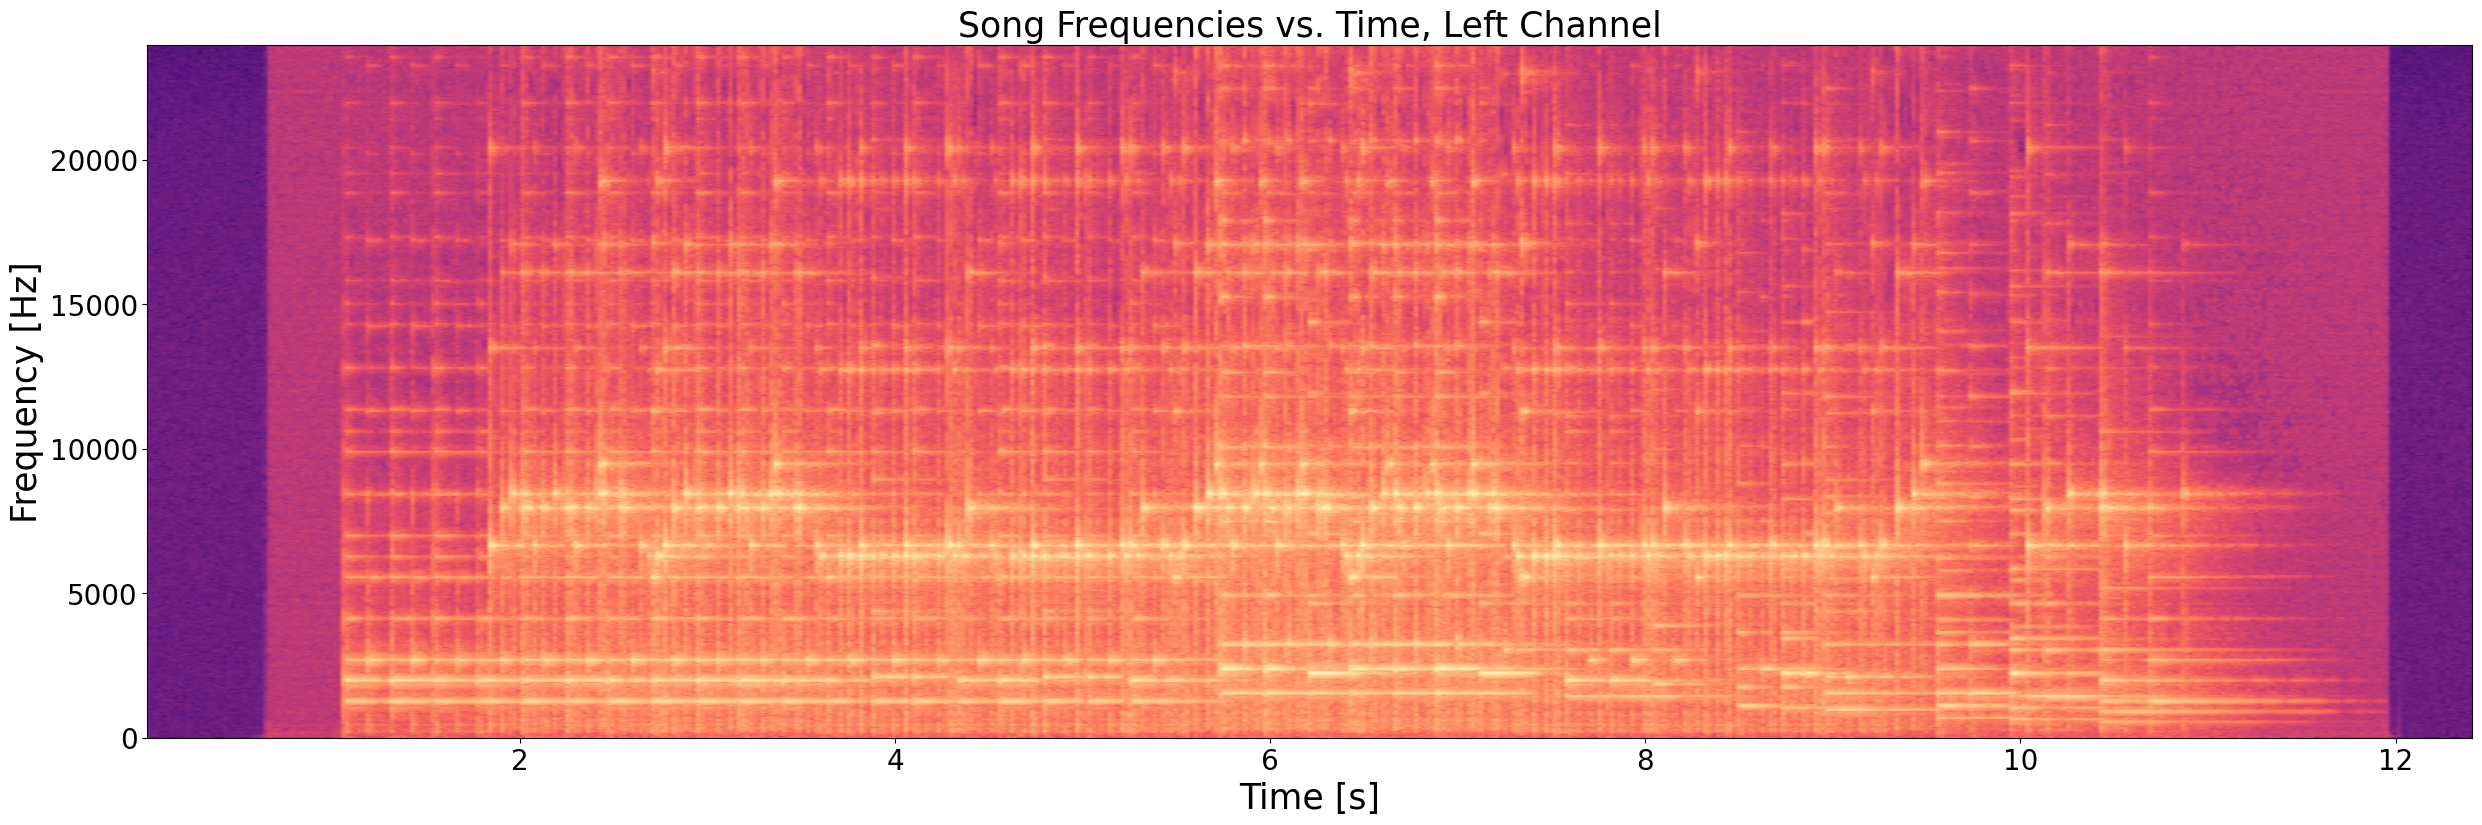

In [407]:
plt.figure(figsize=(30,9))
plt.contourf(left_times, left_freqs, left_mag_log, 100, cmap='magma')
plt.title('Song Frequencies vs. Time, Left Channel', fontsize=25)
plt.ylabel('Frequency [Hz]', fontsize=25)
plt.xlabel('Time [s]', fontsize=25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.show()

In [ ]:
# To-Do

# Subtract off rolling average in frequency space to flatten large-scale variations